# Q4: OOD Detection via Neural Collapse (NECO)

This notebook implements the **NECO** method from:

> Ben Ammar et al., *"NECO: Neural Collapse Based Out-of-Distribution Detection"*, ICLR 2024.

We study:
1. **NC5** — ID/OOD Orthogonality across training epochs
2. **NECO score** — PCA-based OOD detection (eq. 6)
3. **Evaluation** — AUROC & FPR95 on SVHN and CIFAR-10 as OOD datasets
4. **Visualization** — PCA projections, score distributions, ROC curves

## Setup

In [8]:
# Mount Google Drive (for saving checkpoints)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Clone repository
import os
if not os.path.exists('/content/OOD-Detection-Project---CSC_5IA23'):
    !git clone https://github.com/DiegoFleury/OOD-Detection-Project---CSC_5IA23.git
    !git checkout contente
!git stash
!git checkout contente
!git pull
%cd /content/OOD-Detection-Project---CSC_5IA23

No local changes to save
Already on 'contente'
Your branch is up to date with 'origin/contente'.
Already up to date.
/content/OOD-Detection-Project---CSC_5IA23


In [10]:
# Install dependencies
!pip install -q torch torchvision matplotlib seaborn scikit-learn pyyaml imageio tqdm

In [11]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
import glob
import re
import os

from src.models import ResNet18
from src.data import get_cifar100_loaders

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [12]:
# Load config
with open('configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration:")
print(yaml.dump(config, default_flow_style=False))

Configuration:
data:
  augment: true
  data_dir: ./data
  num_workers: 2
device: cuda
model:
  num_classes: 100
ood:
  datasets:
  - SVHN
paths:
  checkpoints: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints
  figures: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures
  gifs: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/gifs
  metrics: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics
  results: /content/drive/MyDrive/Colab Notebooks/OOD/Results
  tables: /content/drive/MyDrive/Colab Notebooks/OOD/Results/tables
training:
  batch_size: 128
  checkpoint_frequency: 25
  early_stopping_patience: 999
  epochs: 300
  lr: 0.1
  momentum: 0.9
  val_split: 0.1
  weight_decay: 0.0005



## 1. Load Data

We load:
- **CIFAR-100** as the In-Distribution (ID) dataset
- **SVHN** and **CIFAR-10** as Out-of-Distribution (OOD) datasets

Following the NECO paper (Section 5), we use the standard dataset splits.

In [13]:
# ID data: CIFAR-100
print("Loading CIFAR-100 (ID) dataset...")

train_loader, val_loader, test_loader = get_cifar100_loaders(
    data_dir=config['data']['data_dir'],
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    augment=False,       # No augmentation for feature extraction
    val_split=config['training']['val_split']
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading CIFAR-100 (ID) dataset...


100%|██████████| 169M/169M [00:02<00:00, 75.2MB/s]


Train batches: 352
Val batches: 40
Test batches: 79


In [14]:
# OOD data: SVHN + CIFAR-10
import torchvision
import torchvision.transforms as transforms

# Use same normalization as CIFAR-100 training
ood_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    ),
])

# SVHN
print("Loading SVHN (OOD)...")
svhn_dataset = torchvision.datasets.SVHN(
    root=config['data']['data_dir'],
    split='test',
    transform=ood_transform,
    download=True
)
svhn_loader = torch.utils.data.DataLoader(
    svhn_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=False,
    num_workers=config['data']['num_workers'],
)
print(f"SVHN test samples: {len(svhn_dataset)}")

# CIFAR-10
print("Loading CIFAR-10 (OOD)...")
cifar10_dataset = torchvision.datasets.CIFAR10(
    root=config['data']['data_dir'],
    train=False,
    transform=ood_transform,
    download=True
)
cifar10_loader = torch.utils.data.DataLoader(
    cifar10_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=False,
    num_workers=config['data']['num_workers'],
)
print(f"CIFAR-10 test samples: {len(cifar10_dataset)}")

Loading SVHN (OOD)...


100%|██████████| 64.3M/64.3M [00:05<00:00, 11.8MB/s]


SVHN test samples: 26032
Loading CIFAR-10 (OOD)...


100%|██████████| 170M/170M [00:02<00:00, 77.3MB/s]


CIFAR-10 test samples: 10000


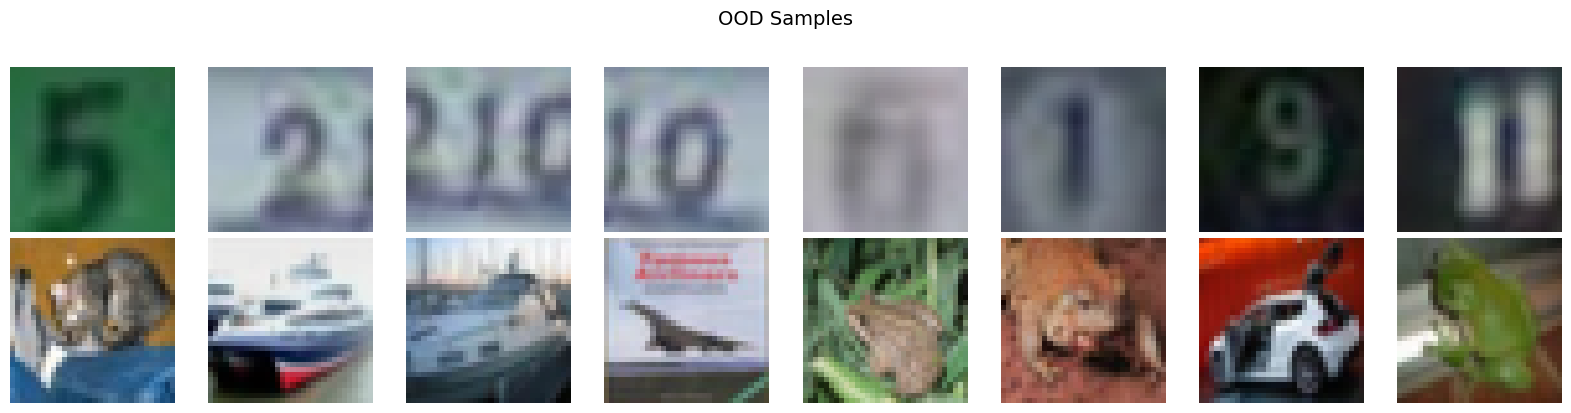

In [15]:
# Visualize OOD samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle("OOD Samples", fontsize=14, y=1.02)

# SVHN
svhn_images, svhn_labels = next(iter(svhn_loader))
for i in range(8):
    img = svhn_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
    img = np.clip(img, 0, 1)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('SVHN', fontsize=12, rotation=0, labelpad=40)

# CIFAR-10
c10_images, c10_labels = next(iter(cifar10_loader))
for i in range(8):
    img = c10_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
    img = np.clip(img, 0, 1)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('CIFAR-10', fontsize=12, rotation=0, labelpad=50)

plt.tight_layout()

ood_fig_dir = os.path.join(config['paths']['figures'], 'ood')
os.makedirs(ood_fig_dir, exist_ok=True)
plt.savefig(os.path.join(ood_fig_dir, 'ood_samples.png'), dpi=150, bbox_inches='tight')
plt.show()

## 2. Load Trained Model

We load the ResNet-18 model trained on CIFAR-100 from notebook Q3.

In [16]:
print("Creating ResNet-18 model...")

model = ResNet18(num_classes=config['model']['num_classes'])

# Load best checkpoint
checkpoint_dir = config['paths']['checkpoints']
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))

def get_epoch_num(path):
    match = re.search(r'epoch(\d+)', path)
    return int(match.group(1)) if match else 0

latest = max(checkpoints, key=get_epoch_num)
epoch_num = get_epoch_num(latest)

ckpt = torch.load(latest, map_location=device, weights_only=False)
if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
    model.load_state_dict(ckpt['model_state_dict'])
elif isinstance(ckpt, dict) and 'state_dict' in ckpt:
    model.load_state_dict(ckpt['state_dict'])
else:
    model.load_state_dict(ckpt)

model = model.to(device)
model.eval()

print(f"✅ Loaded checkpoint: {os.path.basename(latest)} (epoch {epoch_num})")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Creating ResNet-18 model...
✅ Loaded checkpoint: resnet18_cifar100_epoch300.pth (epoch 300)
Total parameters: 11,220,132


## 3. Import NC OOD Module

In [17]:
from src.neural_collapse.nc_ood import (
    load_checkpoints_and_analyze_ood,
    compute_neco_scores,
    evaluate_ood_detection,
    plot_nc5_convergence,
    plot_neco_distributions,
    plot_neco_pca_2d,
    plot_ood_summary,
    save_ood_metrics_yaml,
    NCOODTracker,
    NECOResult,
)

print("✅ NC OOD module imported successfully!")

✅ NC OOD module imported successfully!


## 4. NC5: ID/OOD Orthogonality Across Training

NC5 (eq. 5 of the paper) measures whether ID class means become orthogonal to the OOD global mean during training.

$$\text{OrthoDev} = \text{Avg}_c \left| \frac{\langle \mu_c, \mu_G^{\text{OOD}} \rangle}{\|\mu_c\| \cdot \|\mu_G^{\text{OOD}}\|} \right|$$

This should decrease towards 0 as the model enters the Terminal Phase of Training.

In [18]:
# Configure paths
figures_dir = os.path.join(config['paths']['figures'], 'ood')
metrics_dir = config['paths']['metrics']
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# Verify checkpoints
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))
print(f"📁 Checkpoints found: {len(checkpoints)}")
for ckpt in sorted(checkpoints, key=get_epoch_num)[:5]:
    print(f"   - {os.path.basename(ckpt)}")
if len(checkpoints) > 5:
    print(f"   ... and {len(checkpoints) - 5} more")

📁 Checkpoints found: 13
   - resnet18_cifar100_best.pth
   - resnet18_cifar100_epoch25.pth
   - resnet18_cifar100_epoch50.pth
   - resnet18_cifar100_epoch75.pth
   - resnet18_cifar100_epoch100.pth
   ... and 8 more


In [19]:
# NC5 analysis with SVHN as OOD
print("🔬 Analyzing NC5 with OOD=SVHN...")
print(f"   Device: {device}")
print(f"   ID classes: {config['model']['num_classes']}")
print()

tracker_svhn = load_checkpoints_and_analyze_ood(
    checkpoint_dir=checkpoint_dir,
    model_class=ResNet18,
    id_loader=train_loader,
    ood_loader=svhn_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    checkpoint_pattern='resnet18_cifar100_*.pth',
    epoch_regex=r'epoch(\d+)',
    verbose=True,
)

print("\n" + tracker_svhn.summary())

🔬 Analyzing NC5 with OOD=SVHN...
   Device: cuda
   ID classes: 100



NC+OOD Analysis:   8%|▊         | 1/13 [01:05<13:08, 65.72s/it]

  Epoch    0 | NC5 0.346988 | NC1(ID) 0.1303 | NC1(+OOD) 0.3524 | NC2eq(ID) 0.0570 | NC2eq(+OOD) 0.0575


NC+OOD Analysis:  15%|█▌        | 2/13 [02:12<12:08, 66.27s/it]

  Epoch   25 | NC5 0.458706 | NC1(ID) 4.9756 | NC1(+OOD) 4.6220 | NC2eq(ID) 0.1711 | NC2eq(+OOD) 0.1711


NC+OOD Analysis:  23%|██▎       | 3/13 [03:18<11:03, 66.30s/it]

  Epoch   50 | NC5 0.517990 | NC1(ID) 3.3757 | NC1(+OOD) 3.0596 | NC2eq(ID) 0.1622 | NC2eq(+OOD) 0.1619


NC+OOD Analysis:  31%|███       | 4/13 [04:23<09:52, 65.81s/it]

  Epoch   75 | NC5 0.503133 | NC1(ID) 3.0605 | NC1(+OOD) 2.7614 | NC2eq(ID) 0.1501 | NC2eq(+OOD) 0.1500


NC+OOD Analysis:  38%|███▊      | 5/13 [05:27<08:41, 65.13s/it]

  Epoch  100 | NC5 0.491883 | NC1(ID) 2.4806 | NC1(+OOD) 2.6058 | NC2eq(ID) 0.1392 | NC2eq(+OOD) 0.1391


NC+OOD Analysis:  46%|████▌     | 6/13 [06:33<07:37, 65.41s/it]

  Epoch  125 | NC5 0.505458 | NC1(ID) 2.1624 | NC1(+OOD) 1.9371 | NC2eq(ID) 0.1373 | NC2eq(+OOD) 0.1373


NC+OOD Analysis:  54%|█████▍    | 7/13 [07:39<06:34, 65.69s/it]

  Epoch  150 | NC5 0.495052 | NC1(ID) 1.9183 | NC1(+OOD) 1.8338 | NC2eq(ID) 0.1221 | NC2eq(+OOD) 0.1220


NC+OOD Analysis:  62%|██████▏   | 8/13 [08:46<05:30, 66.03s/it]

  Epoch  175 | NC5 0.503723 | NC1(ID) 1.6058 | NC1(+OOD) 1.4406 | NC2eq(ID) 0.1190 | NC2eq(+OOD) 0.1194


NC+OOD Analysis:  69%|██████▉   | 9/13 [09:55<04:27, 66.85s/it]

  Epoch  200 | NC5 0.510483 | NC1(ID) 1.1183 | NC1(+OOD) 1.1207 | NC2eq(ID) 0.0980 | NC2eq(+OOD) 0.0985


NC+OOD Analysis:  77%|███████▋  | 10/13 [11:00<03:19, 66.35s/it]

  Epoch  225 | NC5 0.479221 | NC1(ID) 0.6443 | NC1(+OOD) 0.7642 | NC2eq(ID) 0.0786 | NC2eq(+OOD) 0.0790


NC+OOD Analysis:  85%|████████▍ | 11/13 [12:05<02:11, 65.85s/it]

  Epoch  250 | NC5 0.379792 | NC1(ID) 0.2081 | NC1(+OOD) 0.3774 | NC2eq(ID) 0.0602 | NC2eq(+OOD) 0.0607


NC+OOD Analysis:  92%|█████████▏| 12/13 [13:11<01:05, 65.83s/it]

  Epoch  275 | NC5 0.342332 | NC1(ID) 0.1353 | NC1(+OOD) 0.3497 | NC2eq(ID) 0.0572 | NC2eq(+OOD) 0.0577


NC+OOD Analysis: 100%|██████████| 13/13 [14:13<00:00, 65.63s/it]

  Epoch  300 | NC5 0.353054 | NC1(ID) 0.1255 | NC1(+OOD) 0.3501 | NC2eq(ID) 0.0567 | NC2eq(+OOD) 0.0573

NC OOD METRICS SUMMARY (NECO)
Epochs analyzed: 13
Epoch range: 0 → 300
Final NC5 OrthoDev: 0.353054
Final NC1 (ID only): 0.1255
Final NC1 (ID+OOD): 0.3501
Final NC2 equiangularity (ID): 0.0567
Final NC2 equiangularity (ID+OOD): 0.0573


In [20]:
# NC5 analysis with CIFAR-10 as OOD
print("🔬 Analyzing NC5 with OOD=CIFAR-10...")
print()

tracker_cifar10 = load_checkpoints_and_analyze_ood(
    checkpoint_dir=checkpoint_dir,
    model_class=ResNet18,
    id_loader=train_loader,
    ood_loader=cifar10_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    checkpoint_pattern='resnet18_cifar100_*.pth',
    epoch_regex=r'epoch(\d+)',
    verbose=True,
)

print("\n" + tracker_cifar10.summary())

🔬 Analyzing NC5 with OOD=CIFAR-10...



NC+OOD Analysis:   8%|▊         | 1/13 [00:50<10:08, 50.70s/it]

  Epoch    0 | NC5 0.442531 | NC1(ID) 0.1303 | NC1(+OOD) 0.8419 | NC2eq(ID) 0.0570 | NC2eq(+OOD) 0.0580


NC+OOD Analysis:  15%|█▌        | 2/13 [01:42<09:25, 51.41s/it]

  Epoch   25 | NC5 0.739536 | NC1(ID) 4.9756 | NC1(+OOD) 7.8508 | NC2eq(ID) 0.1711 | NC2eq(+OOD) 0.1720


NC+OOD Analysis:  23%|██▎       | 3/13 [02:33<08:31, 51.12s/it]

  Epoch   50 | NC5 0.680645 | NC1(ID) 3.3757 | NC1(+OOD) 5.9149 | NC2eq(ID) 0.1622 | NC2eq(+OOD) 0.1630


NC+OOD Analysis:  31%|███       | 4/13 [03:25<07:44, 51.58s/it]

  Epoch   75 | NC5 0.709168 | NC1(ID) 3.0605 | NC1(+OOD) 5.8270 | NC2eq(ID) 0.1501 | NC2eq(+OOD) 0.1510


NC+OOD Analysis:  38%|███▊      | 5/13 [04:17<06:54, 51.84s/it]

  Epoch  100 | NC5 0.679528 | NC1(ID) 2.4806 | NC1(+OOD) 5.2077 | NC2eq(ID) 0.1392 | NC2eq(+OOD) 0.1403


NC+OOD Analysis:  46%|████▌     | 6/13 [05:09<06:02, 51.77s/it]

  Epoch  125 | NC5 0.678971 | NC1(ID) 2.1624 | NC1(+OOD) 4.9506 | NC2eq(ID) 0.1373 | NC2eq(+OOD) 0.1378


NC+OOD Analysis:  54%|█████▍    | 7/13 [06:01<05:10, 51.80s/it]

  Epoch  150 | NC5 0.692226 | NC1(ID) 1.9183 | NC1(+OOD) 5.0952 | NC2eq(ID) 0.1221 | NC2eq(+OOD) 0.1231


NC+OOD Analysis:  62%|██████▏   | 8/13 [06:52<04:17, 51.42s/it]

  Epoch  175 | NC5 0.689067 | NC1(ID) 1.6058 | NC1(+OOD) 4.7200 | NC2eq(ID) 0.1190 | NC2eq(+OOD) 0.1199


NC+OOD Analysis:  69%|██████▉   | 9/13 [07:45<03:27, 51.95s/it]

  Epoch  200 | NC5 0.651299 | NC1(ID) 1.1183 | NC1(+OOD) 4.5507 | NC2eq(ID) 0.0980 | NC2eq(+OOD) 0.0992


NC+OOD Analysis:  77%|███████▋  | 10/13 [08:35<02:34, 51.47s/it]

  Epoch  225 | NC5 0.603589 | NC1(ID) 0.6443 | NC1(+OOD) 3.4370 | NC2eq(ID) 0.0786 | NC2eq(+OOD) 0.0798


NC+OOD Analysis:  85%|████████▍ | 11/13 [09:28<01:43, 51.88s/it]

  Epoch  250 | NC5 0.488176 | NC1(ID) 0.2081 | NC1(+OOD) 1.1888 | NC2eq(ID) 0.0602 | NC2eq(+OOD) 0.0613


NC+OOD Analysis:  92%|█████████▏| 12/13 [10:19<00:51, 51.61s/it]

  Epoch  275 | NC5 0.445526 | NC1(ID) 0.1353 | NC1(+OOD) 0.8671 | NC2eq(ID) 0.0572 | NC2eq(+OOD) 0.0582


NC+OOD Analysis: 100%|██████████| 13/13 [11:11<00:00, 51.66s/it]

  Epoch  300 | NC5 0.439671 | NC1(ID) 0.1255 | NC1(+OOD) 0.8135 | NC2eq(ID) 0.0567 | NC2eq(+OOD) 0.0577

NC OOD METRICS SUMMARY (NECO)
Epochs analyzed: 13
Epoch range: 0 → 300
Final NC5 OrthoDev: 0.439671
Final NC1 (ID only): 0.1255
Final NC1 (ID+OOD): 0.8135
Final NC2 equiangularity (ID): 0.0567
Final NC2 equiangularity (ID+OOD): 0.0577


### 4.1 Plot NC5 Convergence

Reproducing Figure 1 (right) and Figure D.11 from the NECO paper.

💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/nc5_convergence.png


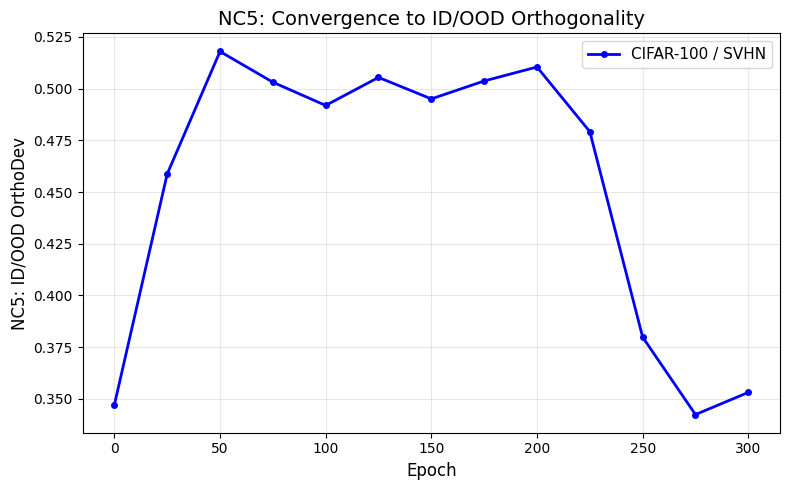

💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/nc5_convergence.png


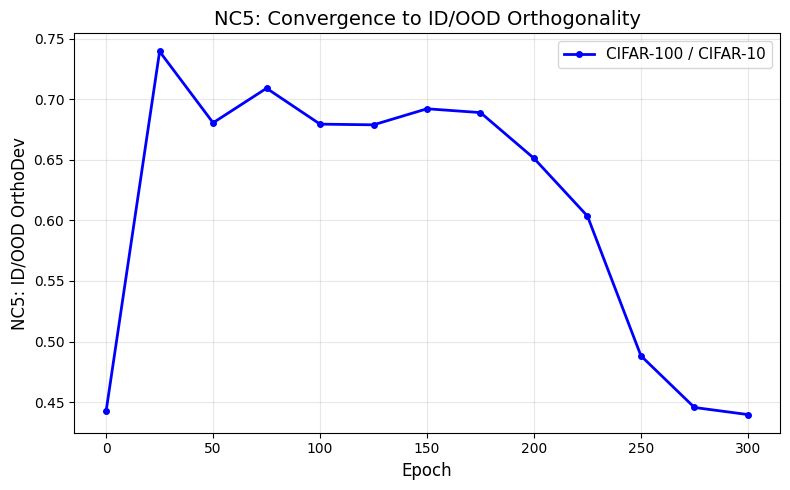

In [21]:
# NC5 convergence — individual plots per OOD dataset
fig_svhn = plot_nc5_convergence(
    tracker_svhn,
    ood_name="SVHN",
    id_name="CIFAR-100",
    save_dir=figures_dir,
)
plt.show()

fig_cifar10 = plot_nc5_convergence(
    tracker_cifar10,
    ood_name="CIFAR-10",
    id_name="CIFAR-100",
    save_dir=figures_dir,
)
plt.show()

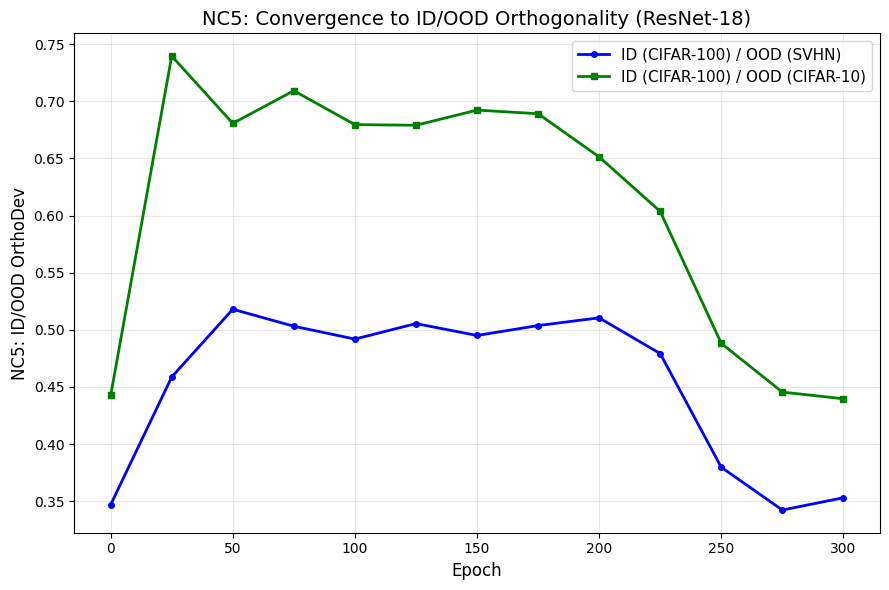

Final NC5 OrthoDev (SVHN):     0.353054
Final NC5 OrthoDev (CIFAR-10): 0.439671


In [22]:
# Combined NC5 plot (both OOD datasets, like Fig 1 in the paper)
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    tracker_svhn.epochs, tracker_svhn.nc5_orthodev,
    'b-o', markersize=4, linewidth=2,
    label='ID (CIFAR-100) / OOD (SVHN)',
)
ax.plot(
    tracker_cifar10.epochs, tracker_cifar10.nc5_orthodev,
    'g-s', markersize=4, linewidth=2,
    label='ID (CIFAR-100) / OOD (CIFAR-10)',
)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('NC5: ID/OOD OrthoDev', fontsize=12)
ax.set_title('NC5: Convergence to ID/OOD Orthogonality (ResNet-18)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
fig.tight_layout()

plt.savefig(os.path.join(figures_dir, 'nc5_combined.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Final NC5 OrthoDev (SVHN):     {tracker_svhn.nc5_orthodev[-1]:.6f}")
print(f"Final NC5 OrthoDev (CIFAR-10): {tracker_cifar10.nc5_orthodev[-1]:.6f}")

### 4.2 NC Summary with OOD (NC1, NC2 with OOD as extra class)

Following Appendix D.2 of the paper, we compare NC1 and NC2 metrics computed on ID data only vs. ID+OOD (treating OOD as an additional class).

💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/nc_ood_summary.png


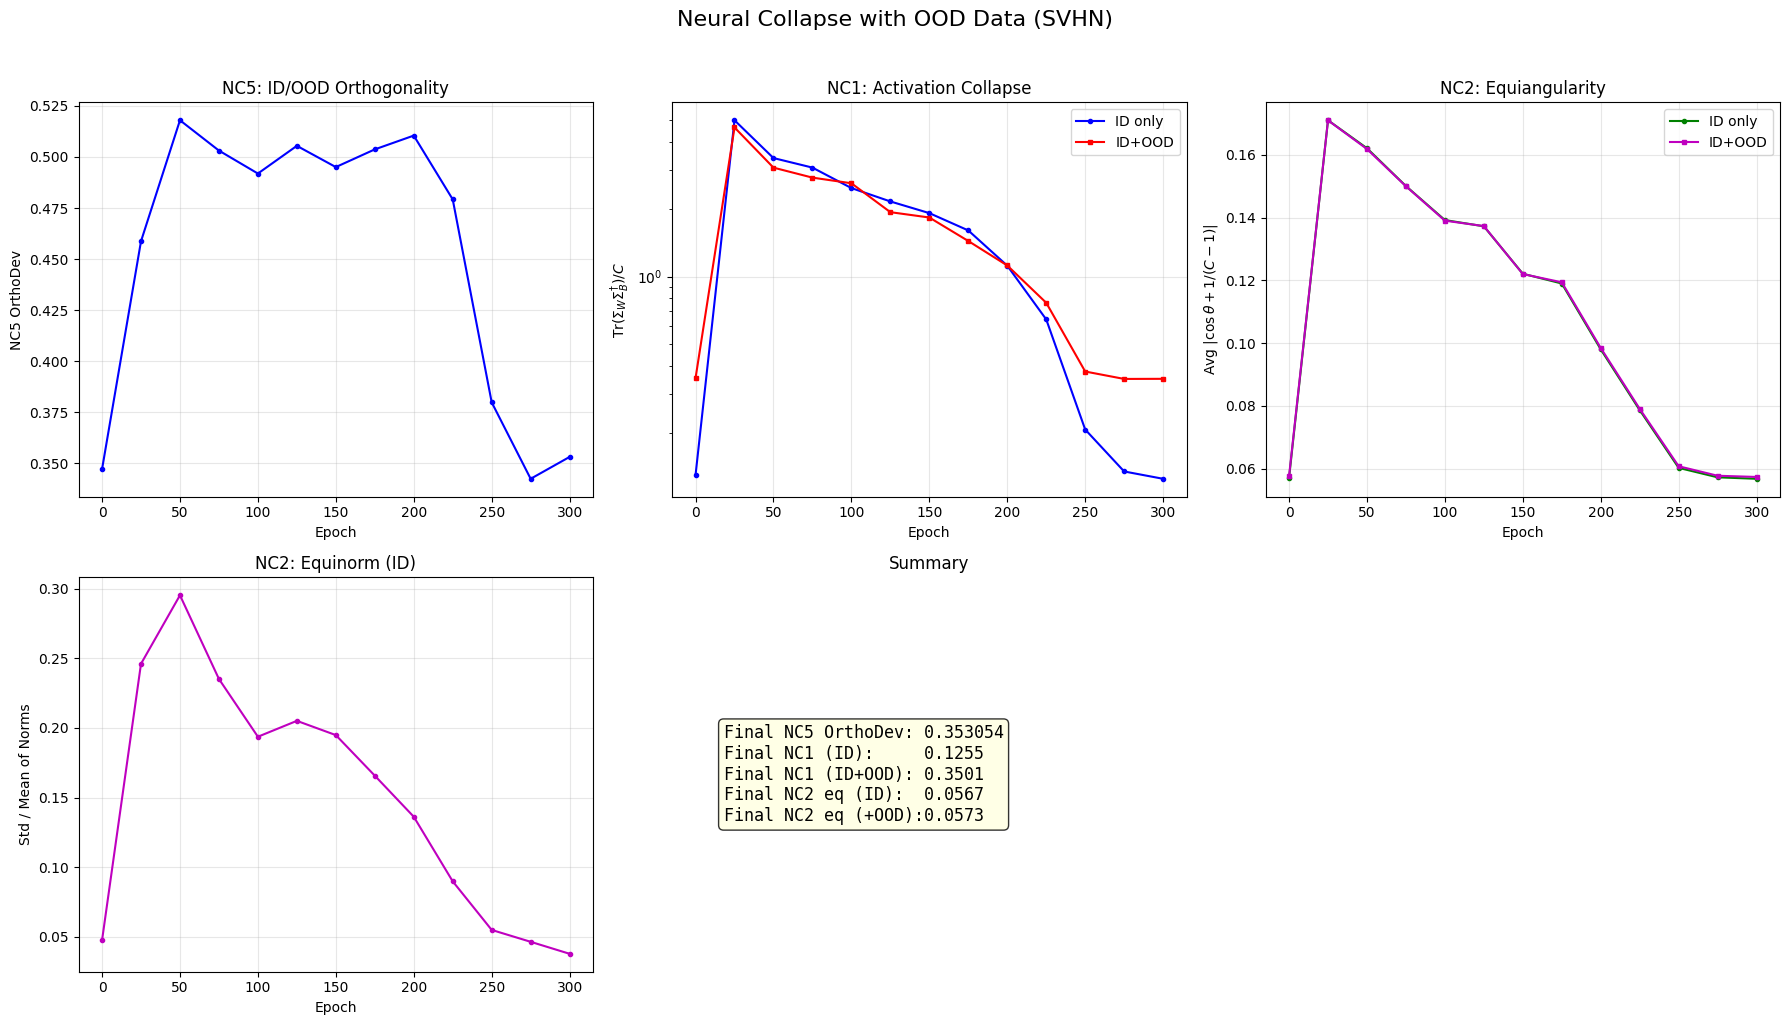

💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/nc_ood_summary.png


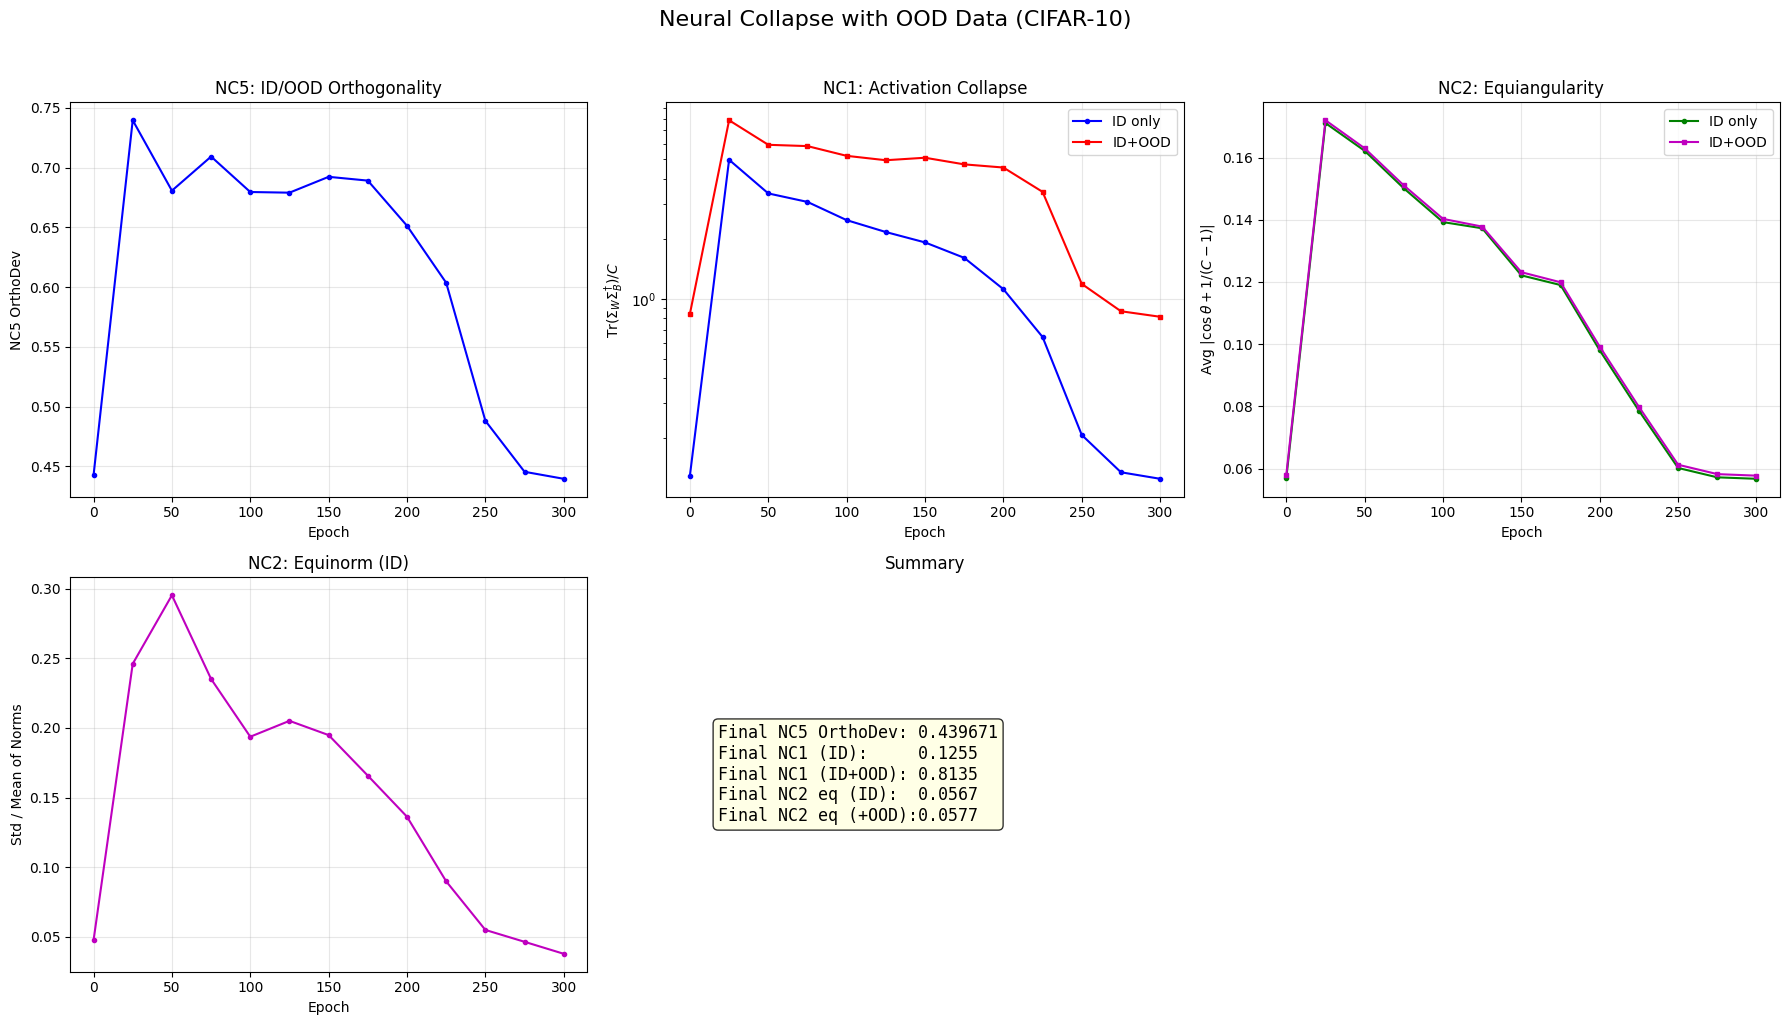

In [23]:
# Full OOD summary plots
fig_svhn_summary = plot_ood_summary(
    tracker_svhn,
    ood_name="SVHN",
    save_dir=figures_dir,
)
plt.show()

fig_cifar10_summary = plot_ood_summary(
    tracker_cifar10,
    ood_name="CIFAR-10",
    save_dir=figures_dir,
)
plt.show()

## 5. NECO Score & OOD Detection

The NECO score (eq. 6) measures the relative projection of a feature vector onto the principal subspace of the ID data:

$$\text{NECO}(\mathbf{x}) = \frac{\|P \, h_\omega(\mathbf{x})\|}{\|h_\omega(\mathbf{x})\|}$$

where $P$ is the projection matrix from PCA fitted on ID training features.

**Intuition:** If NC1+NC2+NC5 hold, ID features live in a low-dimensional ETF subspace while OOD features project near the origin. So NECO score is high for ID, low for OOD.

In [24]:
# Compute NECO scores — SVHN as OOD
print("🔬 Computing NECO scores (OOD = SVHN)...")

result_svhn = compute_neco_scores(
    model=model,
    id_loader=test_loader,
    ood_loader=svhn_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    id_train_loader=train_loader,   # PCA fitted on training data
    pca_dim=config['model']['num_classes'] - 1,   # C-1 = 99
    use_maxlogit=False,             # False for ResNet (True for ViT)
)

print(f"\n📊 Results (CIFAR-100 vs SVHN):")
print(f"   PCA dim:  {result_svhn.pca_dim}")
print(f"   AUROC:    {result_svhn.auroc:.4f} ({result_svhn.auroc*100:.2f}%)")
print(f"   FPR95:    {result_svhn.fpr95:.4f} ({result_svhn.fpr95*100:.2f}%)")

🔬 Computing NECO scores (OOD = SVHN)...

📊 Results (CIFAR-100 vs SVHN):
   PCA dim:  99
   AUROC:    0.8429 (84.29%)
   FPR95:    0.6451 (64.51%)


In [25]:
# Compute NECO scores — CIFAR-10 as OOD
print("🔬 Computing NECO scores (OOD = CIFAR-10)...")

result_cifar10 = compute_neco_scores(
    model=model,
    id_loader=test_loader,
    ood_loader=cifar10_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    id_train_loader=train_loader,
    pca_dim=config['model']['num_classes'] - 1,
    use_maxlogit=False,
)

print(f"\n📊 Results (CIFAR-100 vs CIFAR-10):")
print(f"   PCA dim:  {result_cifar10.pca_dim}")
print(f"   AUROC:    {result_cifar10.auroc:.4f} ({result_cifar10.auroc*100:.2f}%)")
print(f"   FPR95:    {result_cifar10.fpr95:.4f} ({result_cifar10.fpr95*100:.2f}%)")

🔬 Computing NECO scores (OOD = CIFAR-10)...

📊 Results (CIFAR-100 vs CIFAR-10):
   PCA dim:  99
   AUROC:    0.7186 (71.86%)
   FPR95:    0.8770 (87.70%)


### 5.1 Effect of PCA Dimension

Following Section C.5 and Table C.5 of the paper, we sweep over different PCA dimensions to find the optimal ETF subspace approximation.

In [26]:
# Sweep PCA dimensions (like Figures C.5 / C.6 in the paper)
pca_dims = [10, 20, 30, 50, 70, 99, 130, 150, 200, 250, 300, 400, 470, 500]
# Filter to valid range for ResNet-18 feature dim (512)
pca_dims = [d for d in pca_dims if d < 510]

results_by_dim = {'svhn': {}, 'cifar10': {}}

print("Sweeping PCA dimensions...")
for d in pca_dims:
    # SVHN
    r = compute_neco_scores(
        model=model, id_loader=test_loader, ood_loader=svhn_loader,
        device=device, num_classes=config['model']['num_classes'],
        id_train_loader=train_loader, pca_dim=d, use_maxlogit=False,
    )
    results_by_dim['svhn'][d] = r

    # CIFAR-10
    r = compute_neco_scores(
        model=model, id_loader=test_loader, ood_loader=cifar10_loader,
        device=device, num_classes=config['model']['num_classes'],
        id_train_loader=train_loader, pca_dim=d, use_maxlogit=False,
    )
    results_by_dim['cifar10'][d] = r

    print(f"  d={d:>3d} | SVHN: AUROC={results_by_dim['svhn'][d].auroc:.4f} "
          f"FPR95={results_by_dim['svhn'][d].fpr95:.4f} | "
          f"CIFAR-10: AUROC={results_by_dim['cifar10'][d].auroc:.4f} "
          f"FPR95={results_by_dim['cifar10'][d].fpr95:.4f}")

Sweeping PCA dimensions...
  d= 10 | SVHN: AUROC=0.7780 FPR95=0.7997 | CIFAR-10: AUROC=0.4895 FPR95=0.9521
  d= 20 | SVHN: AUROC=0.7763 FPR95=0.7963 | CIFAR-10: AUROC=0.6074 FPR95=0.9045
  d= 30 | SVHN: AUROC=0.7315 FPR95=0.9136 | CIFAR-10: AUROC=0.6563 FPR95=0.8807
  d= 50 | SVHN: AUROC=0.8238 FPR95=0.7713 | CIFAR-10: AUROC=0.7442 FPR95=0.8305
  d= 70 | SVHN: AUROC=0.8834 FPR95=0.6950 | CIFAR-10: AUROC=0.7594 FPR95=0.8177
  d= 99 | SVHN: AUROC=0.8430 FPR95=0.6447 | CIFAR-10: AUROC=0.7185 FPR95=0.8772
  d=130 | SVHN: AUROC=0.8922 FPR95=0.4981 | CIFAR-10: AUROC=0.7009 FPR95=0.8776
  d=150 | SVHN: AUROC=0.8858 FPR95=0.5179 | CIFAR-10: AUROC=0.7002 FPR95=0.8713
  d=200 | SVHN: AUROC=0.8884 FPR95=0.5170 | CIFAR-10: AUROC=0.7017 FPR95=0.8764
  d=250 | SVHN: AUROC=0.8826 FPR95=0.5400 | CIFAR-10: AUROC=0.7041 FPR95=0.8746
  d=300 | SVHN: AUROC=0.8701 FPR95=0.5872 | CIFAR-10: AUROC=0.7022 FPR95=0.8728
  d=400 | SVHN: AUROC=0.8775 FPR95=0.5605 | CIFAR-10: AUROC=0.7048 FPR95=0.8720
  d=470 | SVH

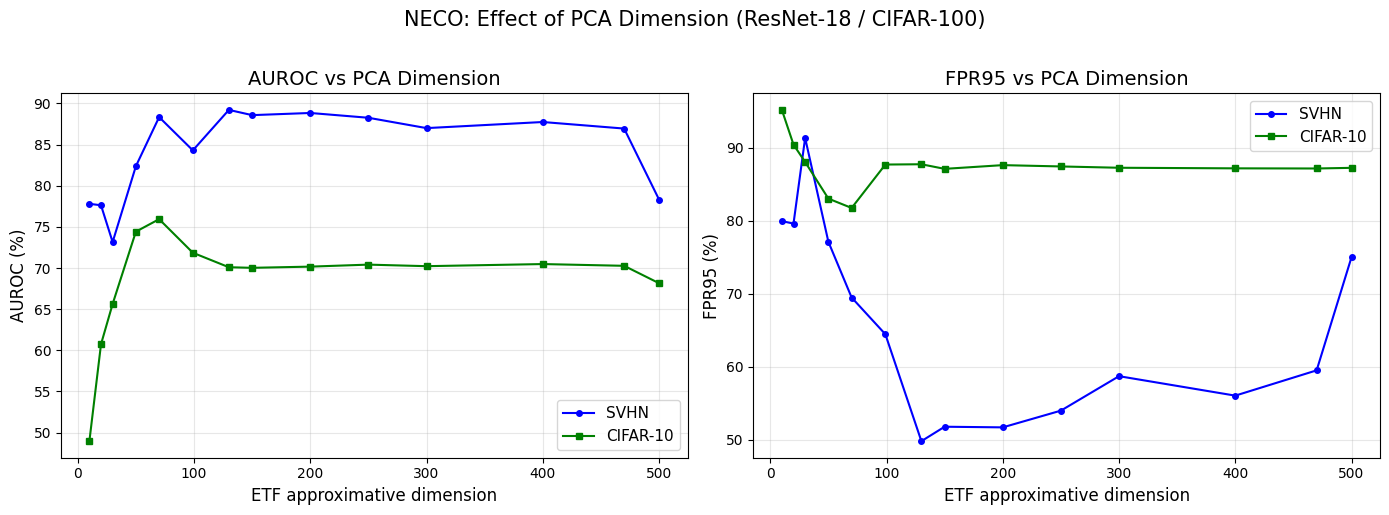

Best d for svhn: 130 (AUROC=0.8922, FPR95=0.4981)
Best d for cifar10: 70 (AUROC=0.7594, FPR95=0.8177)


In [27]:
# Plot AUROC / FPR95 vs PCA dimension
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

dims = sorted(results_by_dim['svhn'].keys())

# AUROC
ax = axes[0]
ax.plot(dims, [results_by_dim['svhn'][d].auroc * 100 for d in dims],
        'b-o', markersize=4, label='SVHN')
ax.plot(dims, [results_by_dim['cifar10'][d].auroc * 100 for d in dims],
        'g-s', markersize=4, label='CIFAR-10')
ax.set_xlabel('ETF approximative dimension', fontsize=12)
ax.set_ylabel('AUROC (%)', fontsize=12)
ax.set_title('AUROC vs PCA Dimensio87.70%)


ax.grid(True, alpha=0.3)

# FPR95
ax = axes[1]
ax.plot(dims, [results_by_dim['svhn'][d].fpr95 * 100 for d in dims],
        'b-o', markersize=4, label='SVHN')
ax.plot(dims, [results_by_dim['cifar10'][d].fpr95 * 100 for d in dims],
        'g-s', markersize=4, label='CIFAR-10')
ax.set_xlabel('ETF approximative dimension', fontsize=12)
ax.set_ylabel('FPR95 (%)', fontsize=12)
ax.set_title('FPR95 vs PCA Dimension', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

fig.suptitle('NECO: Effect of PCA Dimension (ResNet-18 / CIFAR-100)', fontsize=15, y=1.02)
fig.tight_layout()
plt.savefig(os.path.join(figures_dir, 'neco_pca_dim_sweep.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print best dimensions
for ood_name, res_dict in results_by_dim.items():
    best_d = min(res_dict.keys(), key=lambda d: res_dict[d].fpr95)
    print(f"Best d for {ood_name}: {best_d} "
          f"(AUROC={res_dict[best_d].auroc:.4f}, FPR95={res_dict[best_d].fpr95:.4f})")

### 5.2 NECO Score Distributions

Reproducing Figures E.16 and E.17 from the paper. The histograms show how well NECO separates ID from OOD samples.

💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/neco_distributions.png


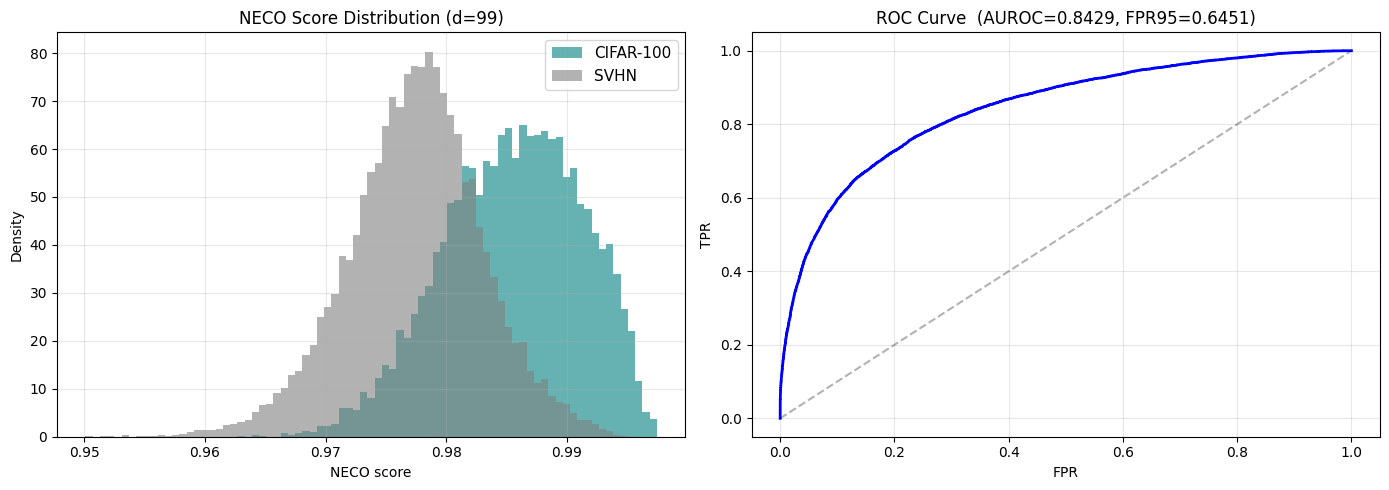

In [28]:
# Score distributions for SVHN
fig_dist_svhn = plot_neco_distribu87.70%)

ions(
    result_svhn,
    id_name="CIFAR-100",
    ood_name="SVHN",
    save_dir=figures_dir,
)
plt.show()

💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/neco_distributions.png


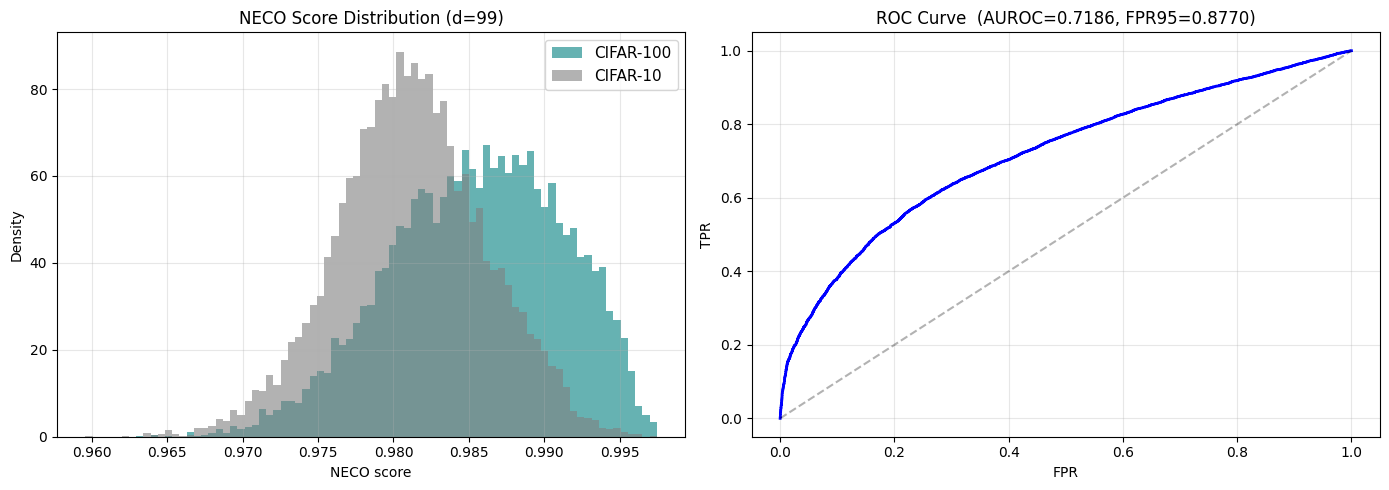

In [29]:
# Score distributions for CIFAR-10
fig_dist_cifar10 = plot_neco_distributions(
    result_cifar10,
    id_name="CIFAR-100",
    ood_name="CIFAR-10",
    save_dir=figures_dir,
)
plt.show()

### 5.3 PCA Feature Projections (2D)

Reproducing Figure 2 / D.14 from the paper. We project ID and OOD features onto the first 2 principal components of a PCA fitted on ID data. Due to NC1, ID classes should form distinct clusters, while NC5 pushes OOD data toward the origin.

💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/neco_pca_2d.png


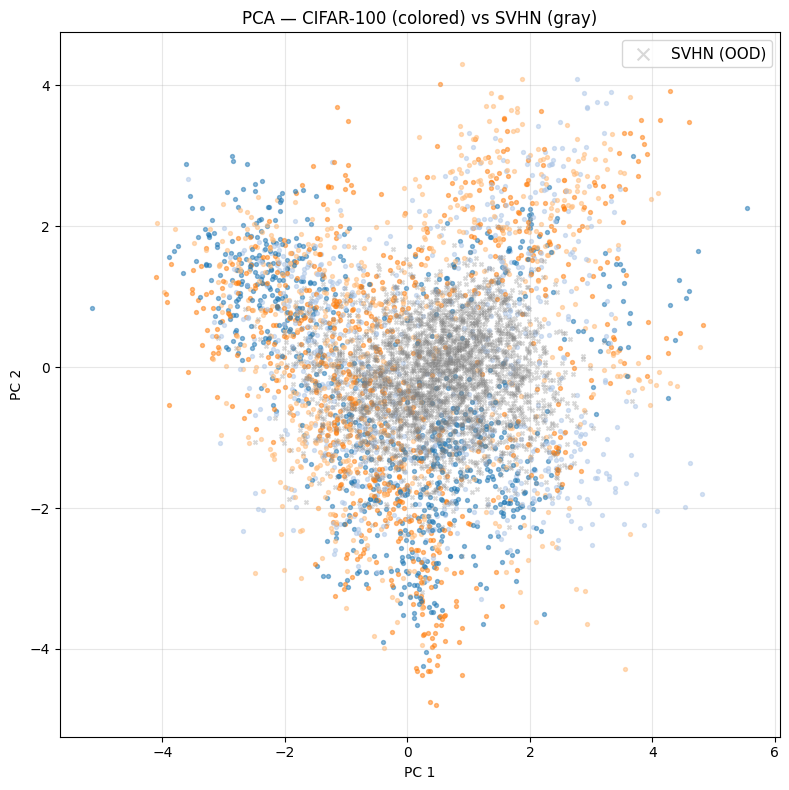

In [30]:
# PCA 2D projection — SVHN
fig_pca_svhn = plot_neco_pca_2d(
    model=model,
    id_loader=test_loader,
    ood_loader=svhn_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    id_name="CIFAR-100",
    ood_name="SVHN",
    max_samples=3000,
    save_dir=figures_dir,
)
plt.show()

💾 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/neco_pca_2d.png


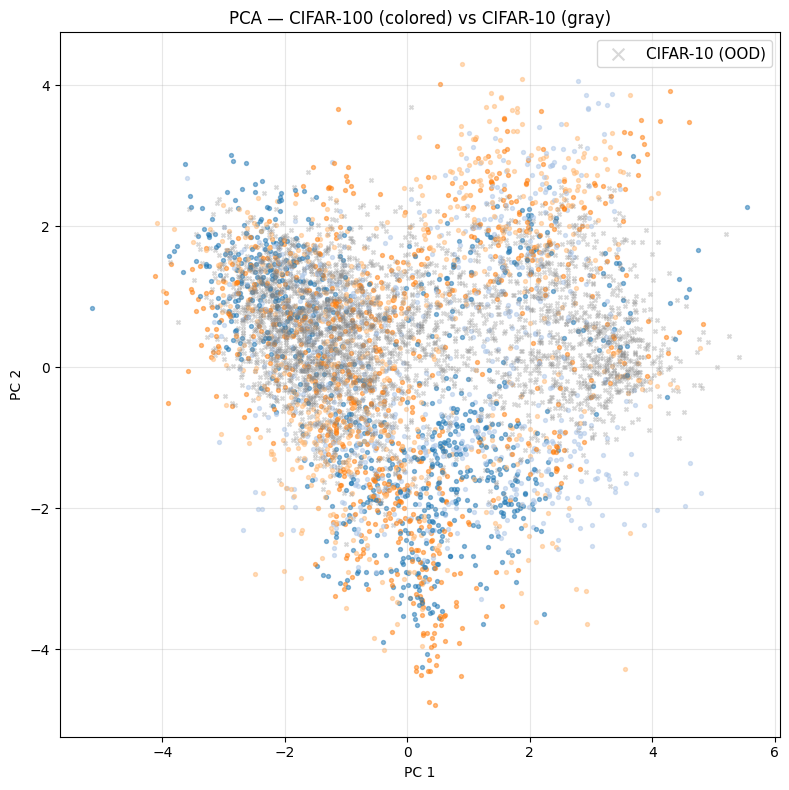

In [31]:
# PCA 2D projection — CIFAR-10
fig_pca_cifar10 = plot_neco_pca_2d(
    model=model,
    id_loader=test_loader,
    ood_loader=cifar10_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    id_name="CIFAR-100",
    ood_name="CIFAR-10",
    max_samples=3000,
    save_dir=figures_dir,
)
plt.show()

## 6. Comparison with Baselines

We compare NECO against simple baseline methods on the same model:
- **MSP** (Maximum Softmax Probability) — Hendrycks & Gimpel, 2017
- **MaxLogit** — Hendrycks et al., 2022
- **Energy** — Liu et al., 2020

In [32]:
# Baseline scoring functions
from src.neural_collapse.nc_ood import _FeatureHook, _find_classifier, _extract_features, evaluate_ood_detection

@torch.no_grad()
def compute_baseline_scores(model, loader, device, method='msp'):
    """Compute baseline OOD scores."""
    model.eval()
    all_scores = []
    for images, targets in loader:
        images = images.to(device)
        logits = model(images)

        if method == 'msp':        # Maximum Softmax Probability
            scores = torch.softmax(logits, dim=1).max(dim=1).values
        elif method == 'maxlogit': # Max Logit
            scores = logits.max(dim=1).values
        elif method == 'energy':   # Energy = logsumexp(logits)
            scores = torch.logsumexp(logits, dim=1)
        else:
            raise ValueError(f"Unknown method: {method}")

        all_scores.append(scores.cpu())

    return torch.cat(all_scores).numpy()


# Compute baselines for both OOD datasets
baselines = {}
for method in ['msp', 'maxlogit', 'energy']:
    for ood_name, ood_loader_i in [('SVHN', svhn_loader), ('CIFAR-10', cifar10_loader)]:
        id_scores = compute_baseline_scores(model, test_loader, device, method)
        ood_scores = compute_baseline_scores(model, ood_loader_i, device, method)
        metrics = evaluate_ood_detection(id_scores, ood_scores)
        baselines[(method, ood_name)] = metrics
        print(f"{method:>10s} | {ood_name:>10s} | "
              f"AUROC={metrics['auroc']:.4f} FPR95={metrics['fpr95']:.4f}")

print("Done!")

       msp |       SVHN | AUROC=0.8064 FPR95=0.8134
       msp |   CIFAR-10 | AUROC=0.7906 FPR95=0.7979
  maxlogit |       SVHN | AUROC=0.8215 FPR95=0.8004
  maxlogit |   CIFAR-10 | AUROC=0.7937 FPR95=0.7939
    energy |       SVHN | AUROC=0.8265 FPR95=0.7822
    energy |   CIFAR-10 | AUROC=0.7937 FPR95=0.7940
Done!


In [33]:
# Summary table
print("\n" + "=" * 70)
print("OOD DETECTION RESULTS — ResNet-18 / CIFAR-100")
print("=" * 70)
print(f"{'Method':>12s} | {'OOD Dataset':>10s} | {'AUROC (%)':>10s} | {'FPR95 (%)':>10s}")
print("-" * 70)

# Baselines
for method in ['msp', 'maxlogit', 'energy']:
    for ood_name in ['SVHN', 'CIFAR-10']:
        m = baselines[(method, ood_name)]
        label = {'msp': 'Softmax', 'maxlogit': 'MaxLogit', 'energy': 'Energy'}[method]
        print(f"{label:>12s} | {ood_name:>10s} | {m['auroc']*100:>10.2f} | {m['fpr95']*100:>10.2f}")

# NECO
print(f"{'NECO':>12s} | {'SVHN':>10s} | {result_svhn.auroc*100:>10.2f} | {result_svhn.fpr95*100:>10.2f}")
print(f"{'NECO':>12s} | {'CIFAR-10':>10s} | {result_cifar10.auroc*100:>10.2f} | {result_cifar10.fpr95*100:>10.2f}")

print("=" * 70)

# Averages
print("\nAverages:")
for method in ['msp', 'maxlogit', 'energy']:
    avg_auroc = np.mean([baselines[(method, o)]['auroc'] for o in ['SVHN', 'CIFAR-10']])
    avg_fpr = np.mean([baselines[(method, o)]['fpr95'] for o in ['SVHN', 'CIFAR-10']])
    label = {'msp': 'Softmax', 'maxlogit': 'MaxLogit', 'energy': 'Energy'}[method]
    print(f"  {label:>10s}: AUROC={avg_auroc*100:.2f}%  FPR95={avg_fpr*100:.2f}%")

neco_avg_auroc = np.mean([result_svhn.auroc, result_cifar10.auroc])
neco_avg_fpr = np.mean([result_svhn.fpr95, result_cifar10.fpr95])
print(f"  {'NECO':>10s}: AUROC={neco_avg_auroc*100:.2f}%  FPR95={neco_avg_fpr*100:.2f}%")


OOD DETECTION RESULTS — ResNet-18 / CIFAR-100
      Method | OOD Dataset |  AUROC (%) |  FPR95 (%)
----------------------------------------------------------------------
     Softmax |       SVHN |      80.64 |      81.34
     Softmax |   CIFAR-10 |      79.06 |      79.79
    MaxLogit |       SVHN |      82.15 |      80.04
    MaxLogit |   CIFAR-10 |      79.37 |      79.39
      Energy |       SVHN |      82.65 |      78.22
      Energy |   CIFAR-10 |      79.37 |      79.40
        NECO |       SVHN |      84.29 |      64.51
        NECO |   CIFAR-10 |      71.86 |      87.70

Averages:
     Softmax: AUROC=79.85%  FPR95=80.57%
    MaxLogit: AUROC=80.76%  FPR95=79.71%
      Energy: AUROC=81.01%  FPR95=78.81%
        NECO: AUROC=78.08%  FPR95=76.10%


## 7. Save Metrics

In [34]:
# Save NC5 tracker metrics
save_ood_metrics_yaml(
    tracker_svhn,
    os.path.join(metrics_dir, 'nc_ood_svhn_metrics.yaml')
)
save_ood_metrics_yaml(
    tracker_cifar10,
    os.path.join(metrics_dir, 'nc_ood_cifar10_metrics.yaml')
)

# Save NECO detection results
import json

neco_results = {
    'model': 'ResNet-18',
    'id_dataset': 'CIFAR-100',
    'results': {
        'SVHN': {
            'auroc': result_svhn.auroc,
            'fpr95': result_svhn.fpr95,
            'pca_dim': result_svhn.pca_dim,
        },
        'CIFAR-10': {
            'auroc': result_cifar10.auroc,
            'fpr95': result_cifar10.fpr95,
            'pca_dim': result_cifar10.pca_dim,
        },
    },
    'baselines': {
        method: {
            ood: baselines[(method, ood)]
            for ood in ['SVHN', 'CIFAR-10']
        }
        for method in ['msp', 'maxlogit', 'energy']
    },
}

json_path = os.path.join(metrics_dir, 'neco_ood_results.json')
with open(json_path, 'w') as f:
    json.dump(neco_results, f, indent=2)
print(f"💾 NECO results saved to: {json_path}")

💾 OOD metrics saved to: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_ood_svhn_metrics.yaml
💾 OOD metrics saved to: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_ood_cifar10_metrics.yaml
💾 NECO results saved to: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/neco_ood_results.json


## 8. Final Summary

In [35]:
print("\n" + "=" * 60)
print("OOD DETECTION SUMMARY (NECO)")
print("=" * 60)

print(f"\nModel: ResNet-18 trained on CIFAR-100")
print(f"Final checkpoint: epoch {epoch_num}")

print(f"\n--- NC5 (ID/OOD Orthogonality) ---")
print(f"  SVHN:     OrthoDev = {tracker_svhn.nc5_orthodev[-1]:.6f}")
print(f"  CIFAR-10: OrthoDev = {tracker_cifar10.nc5_orthodev[-1]:.6f}")

print(f"\n--- NECO OOD Detection ---")
print(f"  SVHN:     AUROC = {result_svhn.auroc*100:.2f}%  |  FPR95 = {result_svhn.fpr95*100:.2f}%")
print(f"  CIFAR-10: AUROC = {result_cifar10.auroc*100:.2f}%  |  FPR95 = {result_cifar10.fpr95*100:.2f}%")
print(f"  Average:  AUROC = {neco_avg_auroc*100:.2f}%  |  FPR95 = {neco_avg_fpr*100:.2f}%")

print(f"\n--- Files Saved ---")
print(f"  Figures:  {figures_dir}/")
print(f"  Metrics:  {metrics_dir}/")

print("\n" + "=" * 60)


OOD DETECTION SUMMARY (NECO)

Model: ResNet-18 trained on CIFAR-100
Final checkpoint: epoch 300

--- NC5 (ID/OOD Orthogonality) ---
  SVHN:     OrthoDev = 0.353054
  CIFAR-10: OrthoDev = 0.439671

--- NECO OOD Detection ---
  SVHN:     AUROC = 84.29%  |  FPR95 = 64.51%
  CIFAR-10: AUROC = 71.86%  |  FPR95 = 87.70%
  Average:  AUROC = 78.08%  |  FPR95 = 76.10%

--- Files Saved ---
  Figures:  /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/ood/
  Metrics:  /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/



## 9. Commit Results to GitHub

In [36]:
# !git add results/figures/ood/
# !git add results/metrics/
# !git commit -m "Add Q4 OOD detection results: NECO + NC5 analysis"
# !git push
#
# print("Results committed to GitHub!")